# Product Sales Forecasting in Retail Industry (Part 3)

### by Sooyeon Won

### Keywords in Part 3
- Sales Forecasting for New Opening Stores 
- Time Series Forecasting Analysis
- ETS Model vs. (Seasonal) ARIMA Model 


## Table of Contents
<ul>
<li><a href="#Introduction">(Part 1) 1. Introduction</a></li> 
<li><a href="#Preparation">(Part 1) 2. Data Preparation</a></li>
<li><a href="#Exploration">(Part 1) 3. Data Exploration</a></li>
<li><a href="#Analysis">(Part 2/ 3) 4. Data Analysis</a></li>
    - (Part 2) 4.1. K-Centroids Diagnostics <br>
    - (Part 2) 4.2. K-Centroids Clustering Analysis<br>
    - (Part 2) 4.3. Classification Models Comparisons <br>
    - (Part 3) 4.4. Time Series Analysis <br>
<li><a href="#Conclusion">(Part 3) 5. Conclusion</a></li>
</ul>

### Datasets from the Analysis Part 1, 2

In [1]:
# Import the relevant libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rc("font", size=14)
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Load the dataset
demographic = pd.read_csv('storedemographicdata.csv')
storeinfo = pd.read_csv('storeinformation.csv')
storesales = pd.read_csv('storesalesdata.csv')
all_store_cluster = pd.read_csv('all_store_cluster.csv')

<a id='Analysis'></a>
## 4. Data Analysis

> To improve the product surplus and shortages, different store formats are introduced. Individual store segments will have a different product selection in order to better match local demand. The actual building sizes will not change, just the product selection and internal layouts. The terms "formats" and "segments" will be used interchangeably throughout this project. 
>- 4.1. Determine Store Segments for Existing Stores (Part 2) <br> The optimal number of store clusters is determined based on 2015 sales data. Percentage values of sales per category per store for clustering (category sales as a percentage of total store sales) are used.<br>
>- 4.2. Cluster the Existing Stores (Part 2) <br> Using a K-means clustering model, the 85 current stores are segmented into the different store clusters.
>- 4.3. Classification Models Comparisons (Part 2) <br> Using classification algorithms (decision tree, forest, and boosted model), I predict  the best store format for each of the 10 new stores. 20% of datapoints are hold out as a test dataset. 
>- **4.4. Forecasting Produce Sales:** <br> Finally, I forecast a monthly produce category sale based on the full year of 2016 for both existing and new stores.

### 4.4. Forecasting Produce Sales

> In this section I prepared a monthly forecast for **produce** sales for the full year of 2016 for both existing and new stores. In general, we should hold at least equivalent number of periods to validate the training. However, we do not have that much data, so taking a 12-month holdout would remove too much of the data. Therefore, I use the last 6 months as a holdout sample. Forecasting section can be specificed in two parts. 

> To do so, we should firstly aggregate produce sales across all existing stores by month. Then we should compare the performance of forecasting time-series models. To forecast produce sales for new stores, we should Forecast "produce" sales (not total sales) for the average store (rather than the aggregate) for each segment. Then we should multiply the average store produce sales forecast by the number of new stores in that cluster and sum up the new stores produce sales forecasts for each of the segments to get the forecast for all new stores. At the end, by aggregating the forecasts of the existing and new stores together for the total produce sales forecast.

><li><a href="#Compare">4.4.1. Compare Time Series Forecasting Models</a></li>
><li><a href="#Holdout">4.4.2. Predict the Holdout Sample</a></li>
><li><a href="#Forecast">4.4.3. Forecast for the next 12 months of Sales</a></li>


<a id='Compare'></a>
### 4.4.1. Compare Time Series Forecasting Models 

>i. Sales Data Visualisation<br>
>ii. Decomposition Plot<br>
>iii. ETS Models & In-Sample Model Accuracy<br>
>iv. Seasonal ARIMA &  In-Sample Model Accuracy<br>

In [3]:
# To forecast sales for existing stores, we need the sales data. 
storesales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116232 entries, 0 to 116231
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                116232 non-null  object 
 1   Day                  116232 non-null  int64  
 2   Month                116232 non-null  int64  
 3   Year                 116232 non-null  int64  
 4   Dry_Grocery          116232 non-null  float64
 5   Dairy                116232 non-null  float64
 6   Frozen_Food          116232 non-null  float64
 7   Meat                 116232 non-null  float64
 8   Produce              116232 non-null  float64
 9   Floral               116232 non-null  float64
 10  Deli                 116232 non-null  float64
 11  Bakery               116232 non-null  float64
 12  General_Merchandise  116232 non-null  float64
dtypes: float64(9), int64(3), object(1)
memory usage: 11.5+ MB


In [4]:
# Filter only "Produce" product sales data 
produce_sales = storesales.iloc[:, np.r_[0,2:4, 8]]
produce_sales.head()

,Store,Month,Year,Produce
0,S0001,3,2012,4542.28
1,S0001,3,2012,9503.45
2,S0001,3,2012,12793.92
3,S0001,3,2012,16635.77
4,S0001,3,2012,8358.96


In [5]:
# Aggregate the "Produce Sales data per each Month"
produce_sales['Date'] = pd.to_datetime(produce_sales[['Year', 'Month']].assign(Day=1))
produce_sales_month=produce_sales.groupby(['Date'])['Produce'].sum()
produce_sales_month.head()

C:\Users\wonso\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Date
2012-03-01    25151525.84
2012-04-01    24406048.39
2012-05-01    28249539.01
2012-06-01    28691364.32
2012-07-01    28535707.45
Name: Produce, dtype: float64

In [6]:
# Split the train and test sets 
sales_train = produce_sales_month.iloc[:-6] # Train set  
sales_test = produce_sales_month.iloc[-6:] # Test set for validation

In [7]:
# Check the size of training & testing sets
sales_train.shape, sales_test.shape

((40,), (6,))

### i. Visualize the Monthly Sales Data

Text(0.5, 1.0, 'Time Series Plots of Sales Amount')

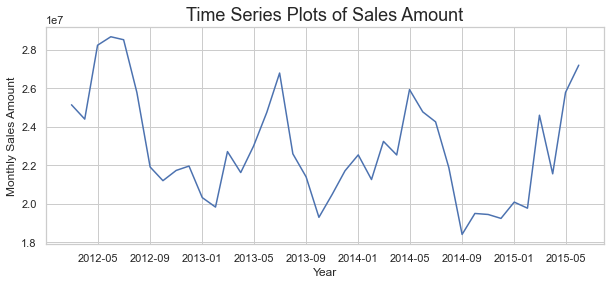

In [8]:
plt.figure(figsize=(10,4))
plt.plot(sales_train.index, sales_train.values)
plt.ylabel('Monthly Sales Amount')
plt.xlabel('Year')
plt.title('Time Series Plots of Sales Amount', size=18)

> According to the monthly sales plot, the aggregated sales amount of the company seems to have seasonal patterns and generally decreasing trend over the time. To select the most appropriate forecasting models, the time series should be broken down into systematic and unsystematic components. These can be confirmd through the following decomposition plot. 

### ii. Determine Trend, Seasonal, and Error components

Text(0.5, 0.98, 'Decomposition Plot')

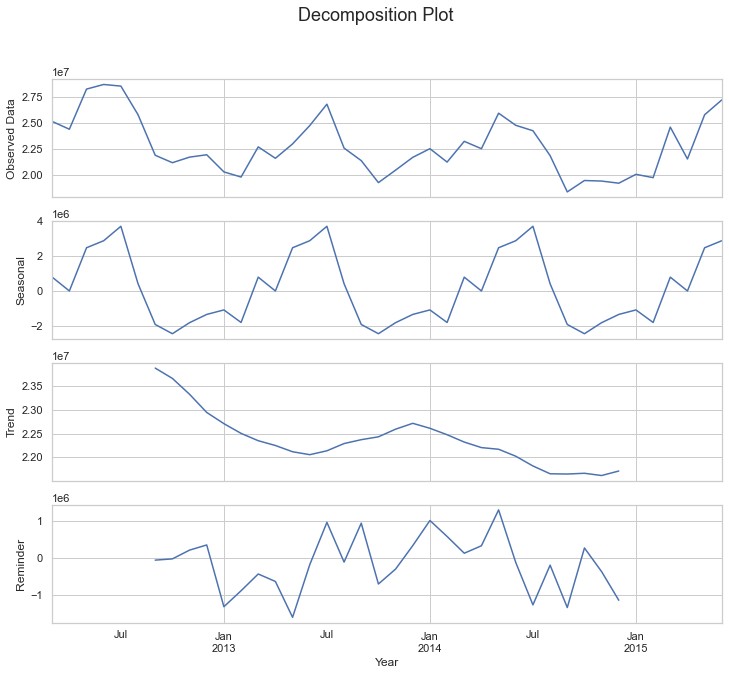

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(sales_train , model='additive', period=12)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Reminder')

plt.xlabel("Year")
plt.suptitle('Decomposition Plot',fontsize = 18)

> The decomposition plot shows the monthly sales data broken down into its three components: trend, seasonal and the error. Each of these components makes up the time series and helps confirm what we saw in the previous initial time series plot.

> The above Decomposition Plot clearly shows that there is a seasonality in the data. Also, when we look at the seasonal peaks and valleys, we can carefully recognize that the magnitude of seasonality is slightly decreasing. The trend line doesn’t indicate monotonous fashion. Finally, error shows changing variance as the time series moves along. Thus, my expectation of the most appropriate ETS model is ETS (M, N, M). The ETS (M, N, M) has the lowest AIC value, comparing to other possible ETS models.

### iii. ETS Models

ETS stands for Error, Trend, and Seasonality, and are the three inputs in ETS models. From the decomposition plot, we could obtain the necessary information to define the terms for the ETS model.

The Trend line exhibits linear behavior so we will use an no-trend method.
The Seasonality changes in magnitude each year so a multiplicative method seems necessary.
The Error changes in magnitude as the series goes along so a multiplicative method will be used.
This leaves us with an **ETS (M, N, M)** model.

In [10]:
# Import the relevant libraries 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [11]:
# Define the ETS (M, N, M) model
ets_model = ETSModel(sales_train, 
                     error='mul', trend=None , seasonal = 'mul', 
                     damped_trend=False, seasonal_periods=12, 
                     initial_level=sales_train.values.mean(), freq='MS')
# Fit the model 
ets_fitted = ets_model.fit()

In [12]:
print(ets_fitted.summary())

                                 ETS Results                                  
Dep. Variable:                Produce   No. Observations:                   40
Model:                       ETS(MNM)   Log Likelihood                -607.565
Date:                Wed, 28 Oct 2020   AIC                           1247.131
Time:                        11:59:26   BIC                           1274.153
Sample:                    03-01-2012   HQIC                          1256.901
                         - 06-01-2015   Scale                            0.002
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6731      0.091      7.396      0.000       0.495       0.851
smoothing_seasonal   3.269e-05        nan        nan        nan         nan         nan
initial_level   

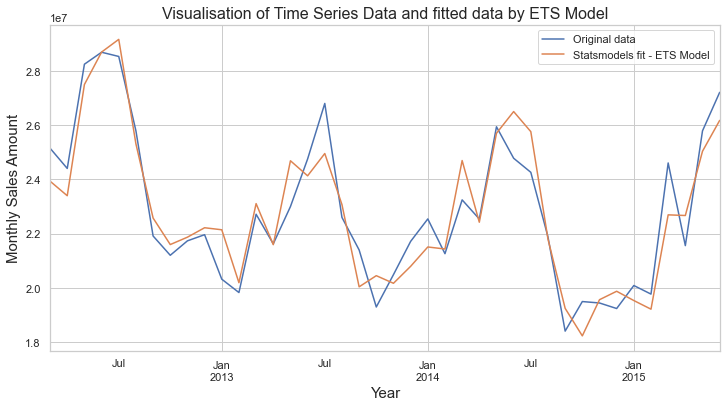

In [13]:
# Visualize the initial TS data and fitted values 
plt.figure(figsize=(12,6))
sales_train.plot(label='Original data')
ets_fitted.fittedvalues.plot(label='Statsmodels fit - ETS Model')
plt.title('Visualisation of Time Series Data and fitted data by ETS Model' , fontsize=16)
plt.ylabel("Monthly Sales Amount",fontsize = 15)
plt.xlabel("Year",fontsize = 15)
plt.legend();

In [14]:
pred_ets= ets_fitted.fittedvalues # Store the predicted values based on ETS model as "pred_ets"

### ETS Models - Evaluating In-Sample Accuracy 

Now, I describe the in-sample errors based on ETS models. The in-sample error measures give us a look at how well our model is able to predict future values. Among the various Error Terms, I chose:

- RMSE (Rooted Mean Squared Error)
- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)
- MASE (Mean Absolute Scaled Error)
For some error terms, I directly use the existing functions from the scikit-learn library. Otherwise, I calculate the error terms for a list of predictions. <br>[Reference: Time Series Forecasting Performance Measures With Python](https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/)

In [15]:
expected_ets = sales_train.values
predicted_ets = pred_ets.values

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

def mean_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true * 100)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def running_diff(arr, N):
    return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])

def mean_absolute_scaled_error(training_series, testing_series, prediction_series):
    errors_mean = np.abs(testing_series - prediction_series ).mean()
    d = np.abs(running_diff(training_series, 12) ).mean()
    return errors_mean/d

mse_ets  = mean_squared_error(expected_ets, predicted_ets)
rmse_ets = sqrt(mse_ets)
mae_ets  = mean_absolute_error(expected_ets, predicted_ets)
mpe_ets  = mean_percentage_error(expected_ets, predicted_ets)
mape_ets = mean_absolute_percentage_error(expected_ets, predicted_ets)
mase_ets = mean_absolute_scaled_error(expected_ets, expected_ets, predicted_ets)

print('In-Sample Error Measures of ETS Models:')
print('')
print('- RMSE: %.3f' % rmse_ets)
print('- MAE : %.3f' % mae_ets)
print('- MPE : %.3f' % mpe_ets)
print('- MAPE: %.3f' % mape_ets)
print('- MASE: %.3f' % mase_ets)

In-Sample Error Measures of ETS Models:

- RMSE: 966118.583
- MAE : 790697.555
- MPE : -0.063
- MAPE: 3.470
- MASE: 0.441


### iv. Seasonal ARIMA

In Time Series Analysis, we should start the analysis with a "stationary" data. make the data stationary. As the decomposition plots exhibit, the provided dataset seems to have seasonality and linear Trend. Augmented Dickey Fuller test reminds us the fact that the given data is not stationary.

In [17]:
# Augmented Dickey Fuller test
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(sales_train.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.793553
p-value: 0.059201


> As usual we will determine the detailed Seasonal ARIMA based on (Seasonal) ACF and PACF plots.

#### Time Series ACF and PACF

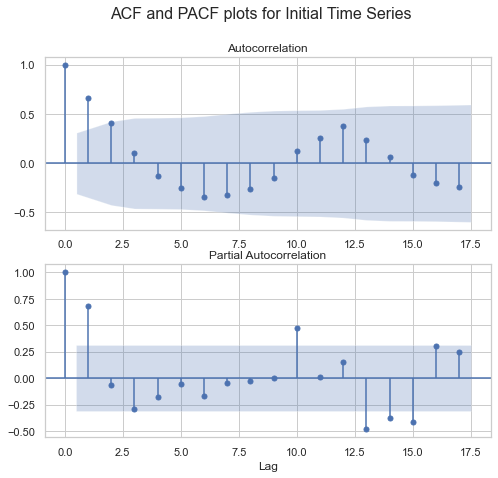

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(211)
fig=plot_acf(sales_train, lags = 17,  ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(sales_train, lags = 17, ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Initial Time Series', fontsize=16)
plt.show()

> The ACF plot is not stationary and shows a seasonal pattern. The time series will be differenced to obtain a stationary time series.

#### Seasonal Difference ACF and PACF

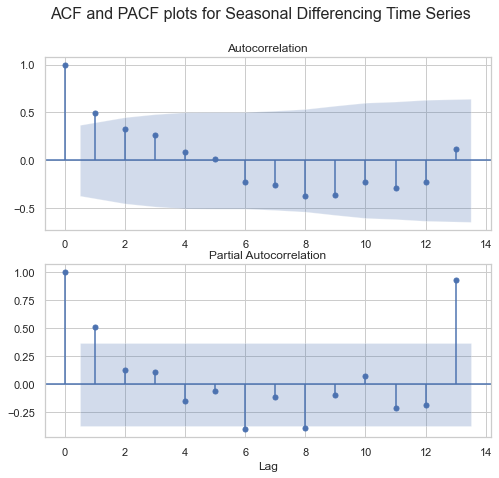

In [19]:
def running_diff(arr, N):
    return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])

seasonal_diff = running_diff(sales_train, 12) 

fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(211)
fig=plot_acf(seasonal_diff, lags = 13, ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(seasonal_diff,lags = 13,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Seasonal Differencing Time Series', fontsize=16)
plt.show()

> The ACF plot of Seasonal Differenced is not stationary as well. It shows a seasonal pattern. The time series will be differenced to obtain a stationary time series.

#### Seasonal First Difference ACF and PACF

C:\Users\wonso\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


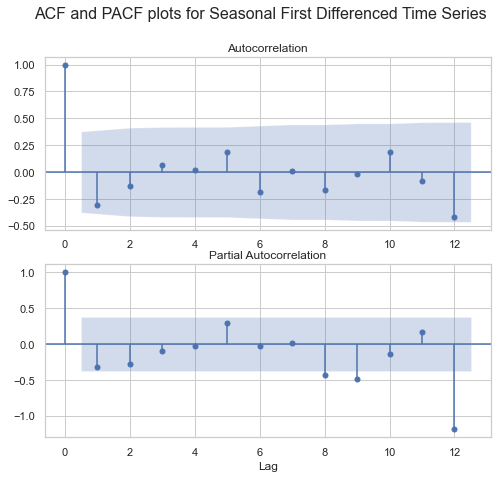

In [20]:
seasonal_diff_1 = running_diff(seasonal_diff, 1) 

fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(211)
fig=plot_acf(seasonal_diff_1, lags=12,  ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(seasonal_diff_1, lags=12,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Seasonal First Differenced Time Series', fontsize=16)
plt.show()

>- From the ACF and PACF of seasonal first difference, the series seems now stationary. 
>- The ACF plot shows a negative correlation at lag-1 which is confirmed in the PACF. This suggests an MA(1) model. In the PACF plot, we can also see plot gradually drops to zero. This indicates MA (1) term (i.e. q =1) as well. 
>- Furthermore, since this is a first difference, the value for d = 1. For the seasonal component at lag -12, in both ACF and PACF the component has negative correlation and is significant. Also, since it is the first difference D = 1. The m value is 12 since seasonal duration is 12 months. The ARIMA model is ARIMA(0,1,1)(0,1,0)[12].

#### Define the Seasonal ARIMA model

In [21]:
# Define model
model_sarima = sm.tsa.statespace.SARIMAX(sales_train, order=(0,1,1), seasonal_order=(0,1,0,12), 
                                         trend = None , freq ='MS', 
                                         enforce_stationarity=False, 
                                         enforce_invertibility=False)
# FIt Model
sarima_fitted = model_sarima.fit(dynamic=False)
print(sarima_fitted.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             Produce   No. Observations:                   40
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -394.403
Date:                             Wed, 28 Oct 2020   AIC                            792.807
Time:                                     11:59:28   BIC                            795.245
Sample:                                 03-01-2012   HQIC                           793.483
                                      - 06-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4436      0.151     -2.931      0.003      -0.740      -0.147
sigma2      3.059e+12   2.1

C:\Users\wonso\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



#### Plot Residual Errors

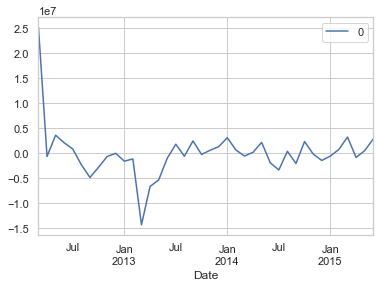

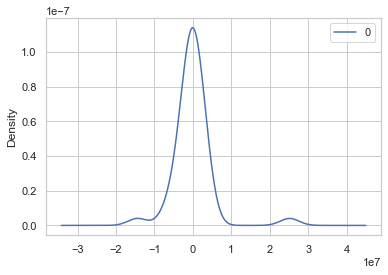

                  0
count  4.000000e+01
mean  -7.045448e+04
std    5.191349e+06
min   -1.443119e+07
25%   -1.578415e+06
50%   -2.967130e+05
75%    1.346422e+06
max    2.515153e+07


In [22]:
residuals = pd.DataFrame(sarima_fitted.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

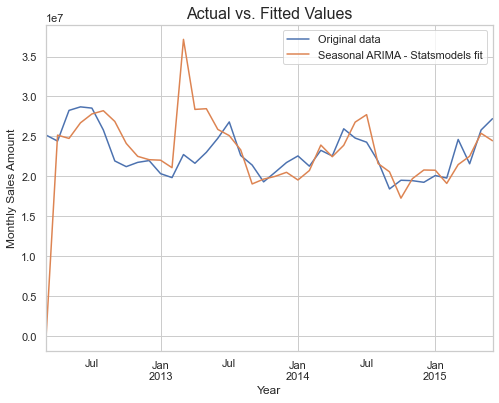

In [23]:
# Compare the Original Time Series and Fitted values 
sales_train.plot(label='Original data',figsize=(8,6))
pred = sarima_fitted.predict()
pred.plot(label='Seasonal ARIMA - Statsmodels fit')
plt.ylabel("Monthly Sales Amount");
plt.xlabel("Year")
plt.title('Actual vs. Fitted Values', fontsize= 16)
plt.legend();

In [24]:
predicted_sarima = sarima_fitted.predict().values
expected_sarima = sales_train.values

mse_sarima  = mean_squared_error(expected_sarima, predicted_sarima)
rmse_sarima = sqrt(mse_sarima)
mae_sarima  = mean_absolute_error(expected_sarima, predicted_sarima)
mpe_sarima  = mean_percentage_error(expected_sarima, predicted_sarima)
mape_sarima = mean_absolute_percentage_error(expected_sarima, predicted_sarima)
mase_sarima = mean_absolute_scaled_error(expected_sarima, expected_sarima, predicted_sarima)

print('In-Sample Error Measures of Seasonal ARIMA Models:')
print(' ')
print('- RMSE : %f' % rmse_sarima)
print('- MAE  : %f' % mae_sarima)
print('- MPE  : %f' % mpe_sarima)
print('- MAPE : %f' % mape_sarima)
print('- MASE : %f' % mase_sarima)

In-Sample Error Measures of Seasonal ARIMA Models:
 
- RMSE : 5126530.255133
- MAE  : 2693244.056581
- MPE  : -0.907254
- MAPE : 11.538478
- MASE : 1.503447


<a id='Holdout'></a>
### 4.4.2. Predict the Holdout Sample

In [25]:
# ETS Model for Validation 
ets_model_holdout = ETSModel(produce_sales_month, 
                             error='mul', trend=None , seasonal = 'mul', 
                             damped_trend=False, seasonal_periods=12, 
                             initial_level=produce_sales_month.values.mean(), 
                             freq='MS')

ets_fitted_holdout = ets_model_holdout.fit()

In [26]:
ets_fitted_holdout.predict()[-6:]

2015-07-01    2.703650e+07
2015-08-01    2.340865e+07
2015-09-01    2.057127e+07
2015-10-01    2.022153e+07
2015-11-01    2.110754e+07
2015-12-01    2.160625e+07
Freq: MS, dtype: float64

In [27]:
# Seasonal ARIMA Model for Validation
model_sarima_holdout = sm.tsa.statespace.SARIMAX(produce_sales_month, 
                                                 order=(0,1,1), seasonal_order=(0,1,0,12), 
                                                 trend = None , freq ='MS', 
                                                 enforce_stationarity=False, 
                                                 enforce_invertibility=False)

sarima_fitted_holdout = model_sarima_holdout.fit(dynamic=False)

C:\Users\wonso\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [28]:
sarima_fitted_holdout.predict()[-6:]

2015-07-01    2.546165e+07
2015-08-01    2.356473e+07
2015-09-01    1.985129e+07
2015-10-01    2.145348e+07
2015-11-01    2.079431e+07
2015-12-01    2.122352e+07
Freq: MS, Name: predicted_mean, dtype: float64

In [29]:
holdout_results = pd.DataFrame({'actual': sales_test.values, 
                                 'predicted_ETS': ets_fitted_holdout.predict()[-6:].values, 
                                 'predicted_ARIMA': sarima_fitted_holdout.predict()[-6:].values },
                                index = sales_test.index) 
holdout_results

,actual,predicted_ETS,predicted_ARIMA
Date,,,
2015-07-01,26338477.15,2.703650e+07,2.546165e+07
2015-08-01,23130626.60,2.340865e+07,2.356473e+07
2015-09-01,20774415.93,2.057127e+07,1.985129e+07
2015-10-01,20359980.58,2.022153e+07,2.145348e+07
2015-11-01,21936906.81,2.110754e+07,2.079431e+07
2015-12-01,20462899.30,2.160625e+07,2.122352e+07


#### Holdout-Sample Errors Comparison

In [30]:
# Holdout-Sample Errors Comparison - ETS Model  
mse_ets_hos  = mean_squared_error(sales_test.values, holdout_results['predicted_ETS'])
rmse_ets_hos = sqrt(mse_ets_hos)
mae_ets_hos  = mean_absolute_error(sales_test.values, holdout_results['predicted_ETS'])
mpe_ets_hos  = mean_percentage_error(sales_test.values, holdout_results['predicted_ETS'])
mape_ets_hos = mean_absolute_percentage_error(sales_test.values, holdout_results['predicted_ETS'])
mase_ets_hos = mean_absolute_scaled_error(sales_train.values, sales_test.values, 
                                         holdout_results['predicted_ETS'])

print('Holdout-Sample Error Measures of ETS Models:')
print(' ')
print('- RMSE : %.3f' % rmse_ets_hos)
print('- MAE  : %.3f' % mae_ets_hos)
print('- MPE  : %.3f' % mpe_ets_hos)
print('- MAPE : %.3f' % mape_ets_hos)
print('- MASE : %.3f' % mase_ets_hos)
print(' ')

# Holdout-Sample Errors Comparison - (Seasonal) ARIMA Model
mse_sarima_hos  = mean_squared_error(sales_test.values, holdout_results['predicted_ARIMA'])
rmse_sarima_hos = sqrt(mse_sarima_hos)
mae_sarima_hos  = mean_absolute_error(sales_test.values, holdout_results['predicted_ARIMA'])
mpe_sarima_hos  = mean_percentage_error(sales_test.values, holdout_results['predicted_ARIMA'])
mape_sarima_hos = mean_absolute_percentage_error(sales_test.values, holdout_results['predicted_ARIMA'])
mase_sarima_hos = mean_absolute_scaled_error(sales_train.values, sales_test.values,  
                                           holdout_results['predicted_ARIMA'])
print(' ')
print('Holdout-Sample Error Measures of Seasonal ARIMA Models:')
print(' ')
print('- RMSE : %.3f' % rmse_sarima_hos)
print('- MAE  : %.3f' % mae_sarima_hos)
print('- MPE  : %.3f' % mpe_sarima_hos)
print('- MAPE : %.3f' % mape_sarima_hos)
print('- MASE : %.3f' % mase_sarima_hos)

Holdout-Sample Error Measures of ETS Models:
 
- RMSE : 660817.426
- MAE  : 548394.248
- MPE  : -0.667
- MAPE : 2.480
- MASE : 0.306
 
 
Holdout-Sample Error Measures of Seasonal ARIMA Models:
 
- RMSE : 902703.681
- MAE  : 871795.211
- MPE  : 0.336
- MAPE : 3.991
- MASE : 0.487


> When we compare the accuracy measures of each model, we can notice that ETS (M, N, M) model shows better performance according to the most of holdout-sample error measurements. The RMSE of ETS model 660817.43 is lower than ARIMA’s 951623.07. Also the MASE of ETS is 0.306. This value is also lower than ARIMA's MASE, which is 0.487. For these reasons, I chose the **ETS (M, N, M)** model for the next 12 months sales forecasting. 

<a id='Forecast'></a>
### 4.4.3. Forecast for the next 12 months of Sales

#### Produce Sales Forecasting for Existing Stores

In [31]:
# ETS Model for Forecasting 
ets_model_final = ETSModel(produce_sales_month, 
                             error='mul', trend=None , seasonal = 'mul', 
                             damped_trend=False, seasonal_periods=12, 
                             initial_level=produce_sales_month.values.mean(), 
                             freq='MS')

ets_fitted_final = ets_model_final.fit()

In [32]:
ets_fitted_final.forecast(12)

2016-01-01    2.112908e+07
2016-02-01    2.040876e+07
2016-03-01    2.363877e+07
2016-04-01    2.237553e+07
2016-05-01    2.557683e+07
2016-06-01    2.622294e+07
2016-07-01    2.642650e+07
2016-08-01    2.325822e+07
2016-09-01    2.059294e+07
2016-10-01    2.011786e+07
2016-11-01    2.090930e+07
2016-12-01    2.088702e+07
Freq: MS, Name: simulation, dtype: float64

In [33]:
pred = ets_fitted_final.get_prediction(start='2016-01-01', end='2016-12-01')

In [34]:
df_95 = pred.summary_frame(alpha=0.05)
df_95.rename(columns = {'mean': 'forecast', 
                        'pi_lower': 'forecast_low_95', 
                        'pi_upper': 'forecast_high_95' }, inplace = True)

In [35]:
df_80 = pred.summary_frame(alpha=0.20)
df_80.rename(columns = {'mean': 'forecast', 
                        'pi_lower': 'forecast_low_80', 
                        'pi_upper': 'forecast_high_80' }, inplace = True)

In [36]:
forecast_results= df_95.merge(df_80[['forecast_low_80', 'forecast_high_80']], how = 'inner', 
                              left_on = df_95.index, right_on = df_80.index, 
                              left_index=True).iloc[:,1:]
forecast_results # Produce sales for existing stores

,forecast,mean_numerical,forecast_low_95,forecast_high_95,forecast_low_80,forecast_high_80
2016-01-01,2.112908e+07,2.111219e+07,1.942732e+07,2.278666e+07,2.003147e+07,2.219873e+07
2016-02-01,2.040876e+07,2.038068e+07,1.841912e+07,2.233831e+07,1.910314e+07,2.161741e+07
2016-03-01,2.363877e+07,2.358116e+07,2.120041e+07,2.623452e+07,2.189907e+07,2.535929e+07
2016-04-01,2.237553e+07,2.235061e+07,1.994777e+07,2.487554e+07,2.075691e+07,2.408242e+07
2016-05-01,2.557683e+07,2.552122e+07,2.251971e+07,2.896417e+07,2.347016e+07,2.762011e+07
2016-06-01,2.622294e+07,2.619351e+07,2.276481e+07,2.975355e+07,2.383948e+07,2.864337e+07
2016-07-01,2.642650e+07,2.636527e+07,2.272154e+07,3.028299e+07,2.384901e+07,2.889118e+07
2016-08-01,2.325822e+07,2.323390e+07,1.972839e+07,2.691637e+07,2.098832e+07,2.571074e+07
2016-09-01,2.059294e+07,2.060267e+07,1.755741e+07,2.411927e+07,1.843351e+07,2.289535e+07
2016-10-01,2.011786e+07,2.017680e+07,1.692487e+07,2.379499e+07,1.791134e+07,2.257722e+07


Text(0.5, 1.0, 'Actual and Forecast Values')

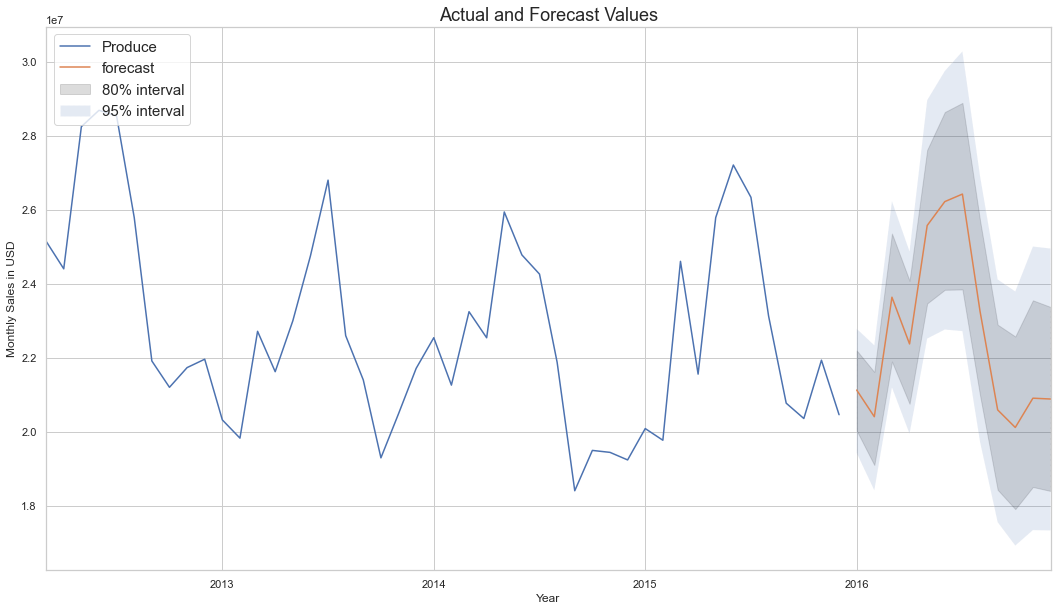

In [37]:
# Visualize the forecast results 
produce_sales_month.plot(figsize=(18,10))
forecast_results.forecast.plot()
upper_series_80 = forecast_results.forecast_high_80
lower_series_80 = forecast_results.forecast_low_80
upper_series_95 = forecast_results.forecast_high_95
lower_series_95 = forecast_results.forecast_low_95

plt.fill_between(upper_series_80.index, 
                 lower_series_80, 
                 upper_series_80, 
                 color='k', alpha=.15, label='80% interval')

plt.fill_between(lower_series_95.index, 
                 lower_series_95, 
                 upper_series_95, 
                 color= None, linestyle ='--', alpha=.15,  label='95% interval')
plt.legend(loc = 'upper left', fontsize =15)
plt.xlabel('Year')
plt.ylabel('Monthly Sales in USD')
plt.title('Actual and Forecast Values', fontsize = 18)

Text(0.5, 1.0, 'Forecasting Simulations')

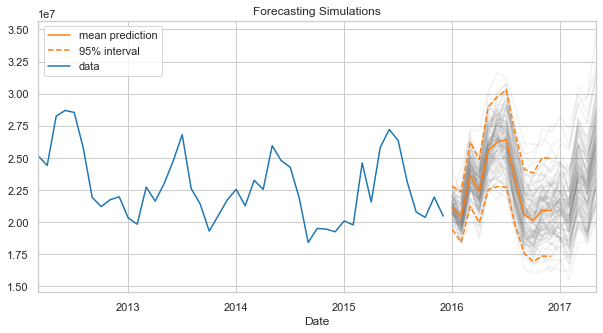

In [38]:
# Forecasting Simulation
simulated = ets_fitted_final.simulate(anchor="end", nsimulations=17, repetitions=100)

for i in range(simulated.shape[1]):
    simulated.iloc[:,i].plot(label='_', color='gray', alpha=0.1)

forecast_results["forecast"].plot(label='mean prediction', color='tab:orange')
forecast_results["forecast_low_95"].plot(linestyle='--', color='tab:orange', label='95% interval')
forecast_results["forecast_high_95"].plot(linestyle='--', color='tab:orange', label='_')
endog = produce_sales_month
produce_sales_month.plot(label='data', figsize =(10,5), color = 'tab:blue')
plt.legend()
plt.title('Forecasting Simulations')

#### Produce Sales Forecasting for New Stores

Next, I forecast Produce category sales for each cluster and then multiplying the results by the number of new stores in that cluster. Then I sum up all of the forecasts on the same months to obtain the total forecast for all the new stores.

In [39]:
storesales.head()

,Store,Day,Month,Year,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
0,S0001,1,3,2012,23401.06,5567.90,3930.28,5223.61,4542.28,238.58,2608.78,1651.77,4304.79
1,S0001,2,3,2012,32442.93,8009.52,4712.31,6174.72,9503.45,245.29,2692.72,2688.89,4467.51
2,S0001,3,3,2012,40433.61,9759.20,5969.03,8010.67,12793.92,282.12,3493.85,2929.85,5721.60
3,S0001,4,3,2012,57043.39,13966.26,9008.24,13142.55,16635.77,316.72,5618.55,4270.38,8313.11
4,S0001,5,3,2012,32894.86,7870.66,5448.35,5459.29,8358.96,198.00,3339.59,2061.21,5280.16


In [40]:
all_store_cluster.head()

,Store,cluster,Type
0,S0001,C,Existing
1,S0002,C,Existing
2,S0003,B,Existing
3,S0004,C,Existing
4,S0005,B,Existing


In [41]:
storesales_cluster = storesales.merge(all_store_cluster, how = 'inner', 
                                      left_on = 'Store', right_on ='Store')
storesales_cluster=storesales_cluster.iloc[:, np.r_[0:4, 8,13]]
storesales_cluster['Date'] = pd.to_datetime(storesales_cluster[['Year', 'Month']].assign(Day=1))

In [42]:
storesales_clusterA = storesales_cluster.query('cluster =="A"')
storesales_clusterB = storesales_cluster.query('cluster =="B"')
storesales_clusterC = storesales_cluster.query('cluster =="C"')

In [43]:
produce_sales_monthA=storesales_clusterA.groupby(['Date'])['Produce'].sum()
produce_sales_monthB=storesales_clusterB.groupby(['Date'])['Produce'].sum()
produce_sales_monthC=storesales_clusterC.groupby(['Date'])['Produce'].sum()

In [44]:
# ETS Model for Validation 
ets_model_finalA = ETSModel(produce_sales_monthA, 
                             error='mul', trend=None , seasonal = 'mul', 
                             damped_trend=False, seasonal_periods=12, 
                             initial_level=produce_sales_month.values.mean(), 
                             freq='MS')

ets_model_finalB = ETSModel(produce_sales_monthB, 
                             error='mul', trend=None , seasonal = 'mul', 
                             damped_trend=False, seasonal_periods=12, 
                             initial_level=produce_sales_month.values.mean(), 
                             freq='MS')

ets_model_finalC = ETSModel(produce_sales_monthC, 
                             error='mul', trend=None , seasonal = 'mul', 
                             damped_trend=False, seasonal_periods=12, 
                             initial_level=produce_sales_month.values.mean(), 
                             freq='MS')

ets_fittedA = ets_model_finalA.fit()
ets_fittedB = ets_model_finalB.fit()
ets_fittedC = ets_model_finalC.fit()

In [45]:
# Average Sales Forecast of Stores in each cluster
avg_fcast_per_cluster= pd.DataFrame({'clusterA': np.round(ets_fittedA.forecast(12)/23,2), 
                                     'clusterB': np.round(ets_fittedB.forecast(12)/29,2) , 
                                    'clusterC': np.round(ets_fittedC.forecast(12)/33,2)})

avg_fcast_per_cluster

,clusterA,clusterB,clusterC
2016-01-01,260303.85,268806.60,223147.60
2016-02-01,251905.50,257619.13,216749.22
2016-03-01,292586.82,294781.40,253490.37
2016-04-01,276815.15,284920.59,235009.59
2016-05-01,313995.09,321543.61,273741.15
2016-06-01,321541.68,328956.97,281467.96
2016-07-01,323766.86,332046.39,283324.75
2016-08-01,283116.18,297396.87,246367.37
2016-09-01,248089.03,267636.34,216161.37
2016-10-01,241289.57,261034.98,212376.77


### Forecasts for Existing and New Stores

In [46]:
new_stores_sales_fcast = ets_fittedA.forecast(12)/23*2 + 
                            ets_fittedB.forecast(12)/29*6 + 
                                ets_fittedC.forecast(12)/33*2

In [47]:
fcast_all = pd.DataFrame({'Existing_Stores': forecast_results.forecast.round(2),
                          'New_Stores': np.round(new_stores_sales_fcast,2),
                          'Total_Sales_Forecast': forecast_results.forecast.round(2)+
                                                          np.round(new_stores_sales_fcast,2)
                          })

In [48]:
fcast_all

,Existing_Stores,New_Stores,Total_Sales_Forecast
2016-01-01,21129079.50,2579742.47,23708821.97
2016-02-01,20408755.01,2483024.19,22891779.20
2016-03-01,23638766.96,2860842.77,26499609.73
2016-04-01,22375533.56,2733172.99,25108706.55
2016-05-01,25576827.06,3104734.12,28681561.18
2016-06-01,26222941.45,3179761.10,29402702.55
2016-07-01,26426501.81,3206461.54,29632963.35
2016-08-01,23258224.12,2843348.34,26101572.46
2016-09-01,20592936.83,2534318.87,23127255.70
2016-10-01,20117864.69,2473542.55,22591407.24


<a id='Conclusion'></a>
### 5. Conclusion

In this analysis, I investigate the sales forecasting of newly opening stores of the company in the retail business. To do so, the following datasets are required. 
- Product category sales records for existing stores
- Demographic data around existing and new stores 
- Each store information data 

In the first part of the analysis, I explored the following current circumstances of the company with visualisations. 
- Traffic Trend 
- Overall Product Sales Trend 
- Demographic Characteristics Comparisons between Existing and New Stores

In the second part of analysis, I mainly conducted the Cluster Analysis as follows. 
- K-Centroids Diagnostics based on various Methods 
- K-Centroids Clustering Analysis - Clusters Comparisons 
- Classification Models (Decision Tree, Random Forest, Boosted Model) Comparisons
- Predict the appropriate Clusters for new Stores 

In the last part of analysis, I forecast product sales of the existing and new stores of the company.
- Time Series Forecasting Models Comparisons 
- Sales Forecasting of the current and new stores for the next 12 months 

This project was the Capstone project of Udacity Nanodegree Program. Therefore, all predictive analytics skills are combined in this project. As earlier mentioned, the outputs are not exactly the same, but highly close to the results from Alteryx, which is the software I used. What is meaningful to me is not just the outcome of the analysis, but the complete understanding of the predictive analytics techniques, which are hidden behind Alteryx tools, and of course, practical usages of python coding. 